# IBM Time Series and Survival Analysis Capstone Project

## Introduction

Litecoin is a peer-to-peer Internet currency that enables instant, near-zero cost payments to anyone in the world. Litecoin is an open source, global payment network that is fully decentralized without any central authorities. Mathematics secures the network and empowers individuals to control their own finances. Litecoin features faster transaction confirmation times and improved storage efficiency than the leading math-based currency. With substantial industry support, trade volume and liquidity, Litecoin is a proven medium of commerce complementary to Bitcoin.

This notebook demonstrates the prediction of the litecoin price by the neural network model. We are using both long short term memory (LSTM) and recurrent neural network (RNN) algorithms, to find the one that suits the problem better.


## Dataset

Litecoin cryptocurrency data were retrieved from [Yahoo Finance](https://in.finance.yahoo.com/quote/LTC-USD/history?p=LTC-USD&.tsrc=fin-srch)

- Date: date of observation
- Open: Opening price on the given day
- High: Highest price on the given day
- Close: Closing price on the given day
- Adjusted Close: Is the closing price after adjustments for all applicable splits and dividend distributions
- Volume: Volume of transactions on the given date


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

In [3]:
Litecoin = pd.read_csv('/content/drive/MyDrive/LTC-USD.csv')

## Data preparation

In [4]:
Litecoin.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1822,2021-05-02,276.960419,277.483459,265.335724,269.104370,269.104370,3.118501e+09
1823,2021-05-03,269.008301,299.300537,268.728973,294.704010,294.704010,5.172505e+09
1824,2021-05-04,294.774261,326.888672,275.464966,306.234497,306.234497,1.154125e+10
1825,2021-05-05,305.177399,359.500153,301.451569,356.037079,356.037079,1.318354e+10
1826,2021-05-06,357.893585,362.496399,327.807770,344.669098,344.669098,9.519699e+09


In [5]:
Litecoin.isnull().values.any()

True

In [6]:
Litecoin.isnull().sum().sum()

24

In [7]:
Litecoin[Litecoin.isnull().any(axis=1)]

,Date,Open,High,Low,Close,Adj Close,Volume
1442,2020-04-17,NaN,NaN,NaN,NaN,NaN,NaN
1617,2020-10-09,NaN,NaN,NaN,NaN,NaN,NaN
1620,2020-10-12,NaN,NaN,NaN,NaN,NaN,NaN
1621,2020-10-13,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
Litecoin['Open'] = Litecoin['Open'].interpolate()
Litecoin['High'] = Litecoin['High'].interpolate()
Litecoin['Low'] = Litecoin['Low'].interpolate()
Litecoin['Close'] = Litecoin['Close'].interpolate()
Litecoin['Adj Close'] = Litecoin['Adj Close'].interpolate()
Litecoin['Volume'] = Litecoin['Volume'].interpolate()

In [9]:
Litecoin.isnull().sum().sum()

0

### Dividing the dataset into training and testing splits

In [10]:
lite_train = Litecoin[Litecoin['Date']< '2021-01-01'].copy()
lite_train

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-05-06,3.716130,3.822110,3.706000,3.822110,3.822110,1.899060e+06
1,2016-05-07,3.819520,4.003440,3.819520,3.953450,3.953450,3.278610e+06
2,2016-05-08,3.936410,3.944110,3.886200,3.938140,3.938140,1.783970e+06
3,2016-05-09,3.937630,4.083380,3.898630,4.056430,4.056430,3.120940e+06
4,2016-05-10,4.057970,4.115630,3.798380,3.819150,3.819150,3.688200e+06
...,...,...,...,...,...,...,...
1696,2020-12-27,129.456619,138.319717,123.097404,127.516968,127.516968,1.410331e+10
1697,2020-12-28,127.588303,136.185074,127.071342,130.050339,130.050339,1.024873e+10
1698,2020-12-29,130.033264,130.608582,121.187202,129.040802,129.040802,9.160551e+09
1699,2020-12-30,129.061859,132.450119,123.444344,129.466080,129.466080,8.127317e+09


In [11]:
lite_test = Litecoin[Litecoin['Date'] > '2021-01-01'].copy()
lite_test

,Date,Open,High,Low,Close,Adj Close,Volume
1702,2021-01-02,126.272964,140.372574,123.693619,136.944885,136.944885,1.053207e+10
1703,2021-01-03,136.949402,163.898636,135.739914,160.190582,160.190582,1.538566e+10
1704,2021-01-04,160.271164,173.027817,143.623962,154.807327,154.807327,1.365979e+10
1705,2021-01-05,154.897552,162.850189,147.400070,158.594772,158.594772,1.019282e+10
1706,2021-01-06,158.665970,169.657455,155.452866,169.016922,169.016922,1.074388e+10
...,...,...,...,...,...,...,...
1822,2021-05-02,276.960419,277.483459,265.335724,269.104370,269.104370,3.118501e+09
1823,2021-05-03,269.008301,299.300537,268.728973,294.704010,294.704010,5.172505e+09
1824,2021-05-04,294.774261,326.888672,275.464966,306.234497,306.234497,1.154125e+10
1825,2021-05-05,305.177399,359.500153,301.451569,356.037079,356.037079,1.318354e+10


In [12]:
train_lt = lite_train.drop(['Date', 'Adj Close'], axis = 1)
train_lt.head()

,Open,High,Low,Close,Volume
0,3.71613,3.82211,3.70600,3.82211,1899060.0
1,3.81952,4.00344,3.81952,3.95345,3278610.0
2,3.93641,3.94411,3.88620,3.93814,1783970.0
3,3.93763,4.08338,3.89863,4.05643,3120940.0
4,4.05797,4.11563,3.79838,3.81915,3688200.0


In [13]:
scaler = MinMaxScaler(feature_range= (0,1))
train_lt = scaler.fit_transform(train_lt)
train_lt

array([[6.38518125e-04, 7.11245300e-04, 1.13793655e-03, 8.27293862e-04,
        8.77429683e-05],
       [9.29236766e-04, 1.19904783e-03, 1.47950707e-03, 1.19746651e-03,
        1.85565038e-04],
       [1.25791557e-03, 1.03944200e-03, 1.68014064e-03, 1.15431634e-03,
        7.95820883e-05],
       ...,
       [3.55825146e-01, 3.41784215e-01, 3.54627329e-01, 3.53747456e-01,
        6.49515689e-01],
       [3.53093688e-01, 3.46738201e-01, 3.61418847e-01, 3.54946073e-01,
        5.76250431e-01],
       [3.54270247e-01, 3.40594268e-01, 3.60191637e-01, 3.41485934e-01,
        4.44874784e-01]])

In [14]:
X_train = []
y_train = []

train_lt.shape

(1701, 5)

In [15]:
for i in range(60, train_lt.shape[0]):
    X_train.append(train_lt[i-60:i])
    y_train.append(train_lt[i,0])

In [16]:
X_train, y_train = np.array(X_train), np.array(y_train)

In [17]:
X_train.shape

(1641, 60, 5)

In [18]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

## LSTM model

In [19]:
regressor = Sequential()
regressor.add(LSTM(units = 50, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], 5)))
regressor.add(Dropout(0.2))

In [20]:
regressor.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
regressor.add(Dropout(0.4))

regressor.add(LSTM(units = 120, activation = 'relu'))
regressor.add(Dropout(0.5))

regressor.add(Dense(units =1))

In [21]:
regressor.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            11200     
_________________________________________________________________
dropout (Dropout)            (None, 60, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 60)            26640     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 60)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 80)            45120     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 80)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 120)               9

In [22]:
from keras import optimizers

optimizer = optimizers.Adam(clipvalue=0.5)

regressor.compile(optimizer = optimizer, loss = 'mean_squared_error')

In [23]:
regressor.fit(X_train, y_train, epochs = 20, batch_size =32)

Epoch 1/20
52/52 [==============================] - 28s 454ms/step - loss: 0.0213
Epoch 2/20
52/52 [==============================] - 24s 462ms/step - loss: 0.0058
Epoch 3/20
52/52 [==============================] - 24s 455ms/step - loss: 0.0067
Epoch 4/20
52/52 [==============================] - 23s 451ms/step - loss: 0.0040
Epoch 5/20
52/52 [==============================] - 24s 456ms/step - loss: 0.0031
Epoch 6/20
52/52 [==============================] - 24s 456ms/step - loss: 0.0033
Epoch 7/20
52/52 [==============================] - 23s 450ms/step - loss: 0.0032
Epoch 8/20
52/52 [==============================] - 24s 457ms/step - loss: 0.0027
Epoch 9/20
52/52 [==============================] - 24s 452ms/step - loss: 0.0022
Epoch 10/20
52/52 [==============================] - 23s 449ms/step - loss: 0.0022
Epoch 11/20
52/52 [==============================] - 23s 450ms/step - loss: 0.0022
Epoch 12/20
52/52 [==============================] - 23s 450ms/step - loss: 0.0021
Epoch 13/20
5

In [24]:
past_60_days = lite_train.tail(60)
lt= past_60_days.append(lite_test, ignore_index = True)
lt = lt.drop(['Date', 'Adj Close'], axis = 1)
lt.head()

,Open,High,Low,Close,Volume
0,55.587322,56.710835,53.205944,53.817482,3.019890e+09
1,53.817410,54.272400,51.648445,53.819622,2.580301e+09
2,53.819469,55.007088,51.606560,54.499104,3.050534e+09
3,54.501873,59.223793,54.501873,58.678497,3.250515e+09
4,58.676193,63.280354,58.465351,63.131111,4.083503e+09


In [25]:
inputs = scaler.transform(lt)
inputs

array([[0.14649327, 0.14298916, 0.1500784 , 0.14173577, 0.21408949],
       [0.14151651, 0.13642943, 0.14539204, 0.1417418 , 0.18291881],
       [0.1415223 , 0.13840584, 0.14526601, 0.14365687, 0.21626243],
       [0.14344113, 0.14974936, 0.15397773, 0.1554362 , 0.23044278],
       [0.15517875, 0.16066206, 0.16590344, 0.16798558, 0.28950892],
       [0.16770538, 0.16367967, 0.16327626, 0.15674719, 0.30634571],
       [0.15649317, 0.1567142 , 0.1671548 , 0.16213434, 0.18150171],
       [0.16186768, 0.1566163 , 0.16402882, 0.15736792, 0.19791029],
       [0.1571169 , 0.15091579, 0.16329215, 0.15419284, 0.16090385],
       [0.15394455, 0.15331251, 0.16512002, 0.15779391, 0.18295357],
       [0.1575361 , 0.15304731, 0.16542201, 0.16019056, 0.17770213],
       [0.15992727, 0.16803526, 0.17145945, 0.1745415 , 0.30662866],
       [0.17424602, 0.16753728, 0.17631918, 0.16979795, 0.20416013],
       [0.16951353, 0.1629931 , 0.1742356 , 0.16558657, 0.18188798],
       [0.16531194, 0.1841119 , 0.

In [26]:
X_test = []
y_test = []
for i in range (60, inputs.shape[0]):
    X_test.append(inputs[i-60:i])
    y_test.append(inputs[i, 0])

In [27]:
X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape, y_test.shape

((125, 60, 5), (125,))

In [28]:
y_pred = regressor.predict(X_test)
y_pred, y_test

(array([[0.25960687],
        [0.25841773],
        [0.26391304],
        [0.27821484],
        [0.29683056],
        [0.31620568],
        [0.33584392],
        [0.35537764],
        [0.37175015],
        [0.384363  ],
        [0.39348674],
        [0.3954489 ],
        [0.38958508],
        [0.37829712],
        [0.36403194],
        [0.3487959 ],
        [0.33404443],
        [0.32170013],
        [0.3149298 ],
        [0.31488097],
        [0.31956702],
        [0.32570446],
        [0.32975867],
        [0.33057946],
        [0.32920912],
        [0.32647035],
        [0.3228251 ],
        [0.31880963],
        [0.31632724],
        [0.31484786],
        [0.3129187 ],
        [0.3104181 ],
        [0.3089343 ],
        [0.31081933],
        [0.316398  ],
        [0.32447952],
        [0.33436936],
        [0.34368506],
        [0.35249925],
        [0.36278874],
        [0.3773867 ],
        [0.3932778 ],
        [0.40919703],
        [0.4301499 ],
        [0.45358604],
        [0

In [29]:
scaler.scale_

array([2.81186421e-03, 2.69013692e-03, 3.00890173e-03, 2.81843036e-03,
       7.09086803e-11])

In [30]:
scale = 1/2.81186421e-03
scale

355.6359501442639

In [31]:
y_test = y_test*scale
y_pred = y_pred*scale

In [32]:
y_pred

array([[ 92.32554 ],
       [ 91.90263 ],
       [ 93.856964],
       [ 98.9432  ],
       [105.56362 ],
       [112.45411 ],
       [119.43817 ],
       [126.38507 ],
       [132.20772 ],
       [136.6933  ],
       [139.93803 ],
       [140.63585 ],
       [138.55046 ],
       [134.53606 ],
       [129.46284 ],
       [124.04436 ],
       [118.79821 ],
       [114.408134],
       [112.00037 ],
       [111.982994],
       [113.64952 ],
       [115.832214],
       [117.27404 ],
       [117.56594 ],
       [117.0786  ],
       [116.10459 ],
       [114.80821 ],
       [113.380165],
       [112.497345],
       [111.97122 ],
       [111.28514 ],
       [110.395836],
       [109.86815 ],
       [110.53853 ],
       [112.52251 ],
       [115.39658 ],
       [118.913765],
       [122.22677 ],
       [125.361404],
       [129.02072 ],
       [134.21228 ],
       [139.86372 ],
       [145.52518 ],
       [152.97678 ],
       [161.31151 ],
       [168.80089 ],
       [174.15111 ],
       [177.8

In [33]:
y_test

array([122.78391405, 133.46035205, 156.78211406, 151.40850206,
       155.17692006, 165.57917207, 166.15247507, 169.76470407,
       173.98813807, 167.60578307, 135.59093706, 129.16988605,
       143.89069506, 148.62247606, 140.69913706, 140.73578806,
       138.94559706, 148.70850606, 149.86704406, 146.45504206,
       126.58478705, 133.70864305, 134.24965805, 137.94922806,
       133.94387205, 131.26240005, 119.45220405, 134.72947105,
       131.51020205, 129.92898005, 126.08555005, 128.46386105,
       138.98768006, 152.16742906, 141.66158506, 151.36503006,
       152.18049006, 147.61846306, 163.72493907, 178.49840707,
       178.57369407, 180.89809607, 193.74527908, 222.79682309,
       210.83594709, 204.12139308, 207.07998108, 233.46019909,
       223.41024209, 233.16585709, 224.03057309, 223.73476609,
       204.63436308, 173.47771607, 177.89637207, 175.63947507,
       166.94237707, 168.61313807, 161.49408907, 171.72063607,
       174.48531507, 184.96926308, 177.55091307, 177.21

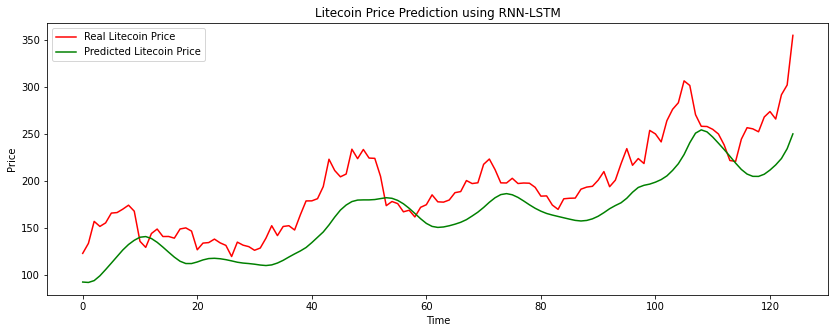

In [35]:
plt.figure(figsize=(14,5))
plt.plot(y_test, color = 'red', label = 'Real Litecoin Price')
plt.plot(y_pred, color = 'green', label = 'Predicted Litecoin Price')
plt.title('Litecoin Price Prediction using RNN-LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

## RNN model

In [38]:
regressor_2 = Sequential()
regressor_2.add(SimpleRNN(units = 50, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], 5)))
regressor_2.add(Dropout(0.2))

In [39]:
regressor_2.add(SimpleRNN(units = 60, activation = 'relu', return_sequences = True))
regressor_2.add(Dropout(0.3))

regressor_2.add(SimpleRNN(units = 80, activation = 'relu', return_sequences = True))
regressor_2.add(Dropout(0.4))

regressor_2.add(SimpleRNN(units = 120, activation = 'relu'))
regressor_2.add(Dropout(0.5))

regressor_2.add(Dense(units =1))

In [40]:
regressor_2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_4 (SimpleRNN)     (None, 60, 50)            2800      
_________________________________________________________________
dropout_7 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 60, 60)            6660      
_________________________________________________________________
dropout_8 (Dropout)          (None, 60, 60)            0         
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 60, 80)            11280     
_________________________________________________________________
dropout_9 (Dropout)          (None, 60, 80)            0         
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, 120)              

In [41]:
regressor_2.compile(optimizer = optimizer, loss = 'mean_squared_error')

In [42]:
regressor_2.fit(X_train, y_train, epochs = 20, batch_size =32)

Epoch 1/20
52/52 [==============================] - 13s 205ms/step - loss: 0.0906
Epoch 2/20
52/52 [==============================] - 11s 208ms/step - loss: 0.0059
Epoch 3/20
52/52 [==============================] - 11s 204ms/step - loss: 0.0039
Epoch 4/20
52/52 [==============================] - 11s 203ms/step - loss: 0.0043
Epoch 5/20
52/52 [==============================] - 11s 206ms/step - loss: 0.0057
Epoch 6/20
52/52 [==============================] - 11s 203ms/step - loss: 0.0033
Epoch 7/20
52/52 [==============================] - 10s 201ms/step - loss: 0.0039
Epoch 8/20
52/52 [==============================] - 10s 199ms/step - loss: 0.0039
Epoch 9/20
52/52 [==============================] - 11s 203ms/step - loss: 0.0031
Epoch 10/20
52/52 [==============================] - 11s 203ms/step - loss: 0.0029
Epoch 11/20
52/52 [==============================] - 11s 202ms/step - loss: 0.0027
Epoch 12/20
52/52 [==============================] - 10s 199ms/step - loss: 0.0027
Epoch 13/20
5

In [43]:
y_pred = regressor_2.predict(X_test)


In [45]:
y_pred = y_pred*scale

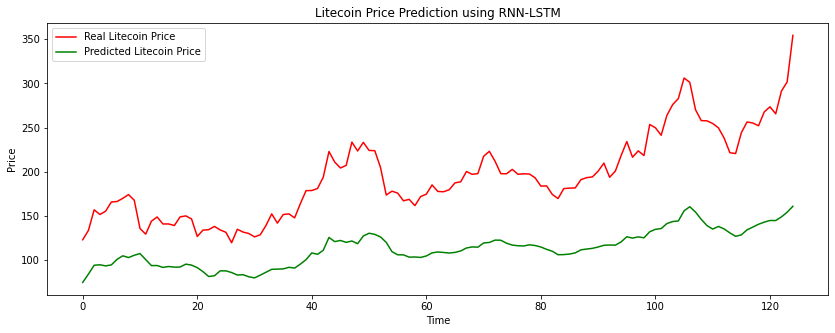

In [46]:
plt.figure(figsize=(14,5))
plt.plot(y_test, color = 'red', label = 'Real Litecoin Price')
plt.plot(y_pred, color = 'green', label = 'Predicted Litecoin Price')
plt.title('Litecoin Price Prediction using RNN-LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

## Conclusion

In this report, two models were created for forecasting the litecoin cryptocurrency price; a Recurent neural network model and a Long Short-Term Memory model. For comparison reasons, the algorithms used the same hyperparameters and both were trained on 20 epochs.

## Results

By comparing the model summary for Simple RNN with the model summary for LSTM, it is evident that there are more trainable parameters for the LSTM (approximately 1:4 ratio for the LSTM), which explains why it took a longer time to train this model. 

Overall the plots show that the LSTM model performs a lot better, compared to the RNN, as it clearly captures the upward trend of the price.

### Next Steps

To improve the quality of forecasts over many time steps, we'd need to use more data and more sophisticated LSTM model structures. We could try training with more data and running more training epochs. An additional recommendation would be to change the hyperparameters to achieve even smaller losses. However, the loss of this simple LSTM model was only 0.019.
